# Evaluation


In [ ]:
import h5py
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams

from config import SpectrogramClassificationConfig
from tqdne.metric import AmplitudeSpectralDensity, frechet_distance
from tqdne.dataset import Dataset
from tqdne.plot import BinPlot, MovingAverageEnvelopeGrid, AmplitudeSpectralDensityGrid

Process ForkPoolWorker-63:
Process ForkPoolWorker-81:
Process ForkPoolWorker-80:
Process ForkPoolWorker-5:
Process ForkPoolWorker-137:
Process ForkPoolWorker-129:
Process ForkPoolWorker-160:
Process ForkPoolWorker-229:
Process ForkPoolWorker-91:
Process ForkPoolWorker-225:
Process ForkPoolWorker-26:
Process ForkPoolWorker-168:
Process ForkPoolWorker-38:
Process ForkPoolWorker-86:
Process ForkPoolWorker-40:
Process ForkPoolWorker-7:
Process ForkPoolWorker-106:
Process ForkPoolWorker-151:
Process ForkPoolWorker-165:
Process ForkPoolWorker-246:
Process ForkPoolWorker-36:
Process ForkPoolWorker-245:
Process ForkPoolWorker-66:
Process ForkPoolWorker-237:
Process ForkPoolWorker-124:
Process ForkPoolWorker-116:
Process ForkPoolWorker-104:
Process ForkPoolWorker-83:
Process ForkPoolWorker-62:
Process ForkPoolWorker-279:
Process ForkPoolWorker-133:
Process ForkPoolWorker-240:
Process ForkPoolWorker-42:
Process ForkPoolWorker-149:
Process ForkPoolWorker-187:
Process ForkPoolWorker-183:
Process F

## Setup

In [ ]:

config = SpectrogramClassificationConfig("workdir")
test = h5py.File("workdir/evaluation/Latent-EDM-LogSpectrogram-split_test.h5", "r")

In [24]:
preds = test["predicted_waveform"][:10]
targets = test["target_waveform"][:10]

In [25]:
targets.shape

(10, 3, 12256)

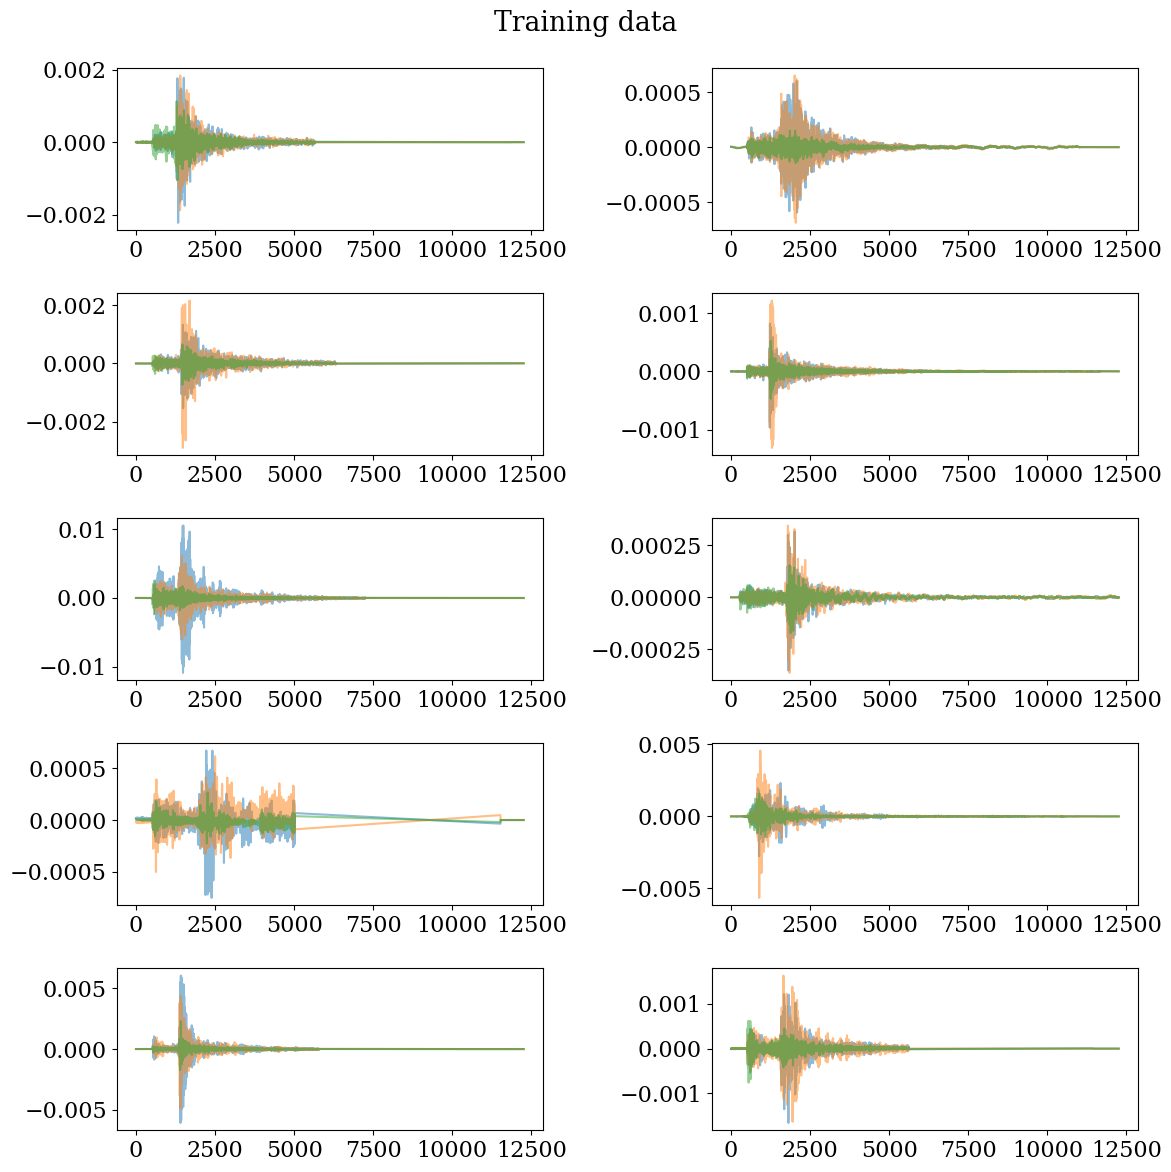

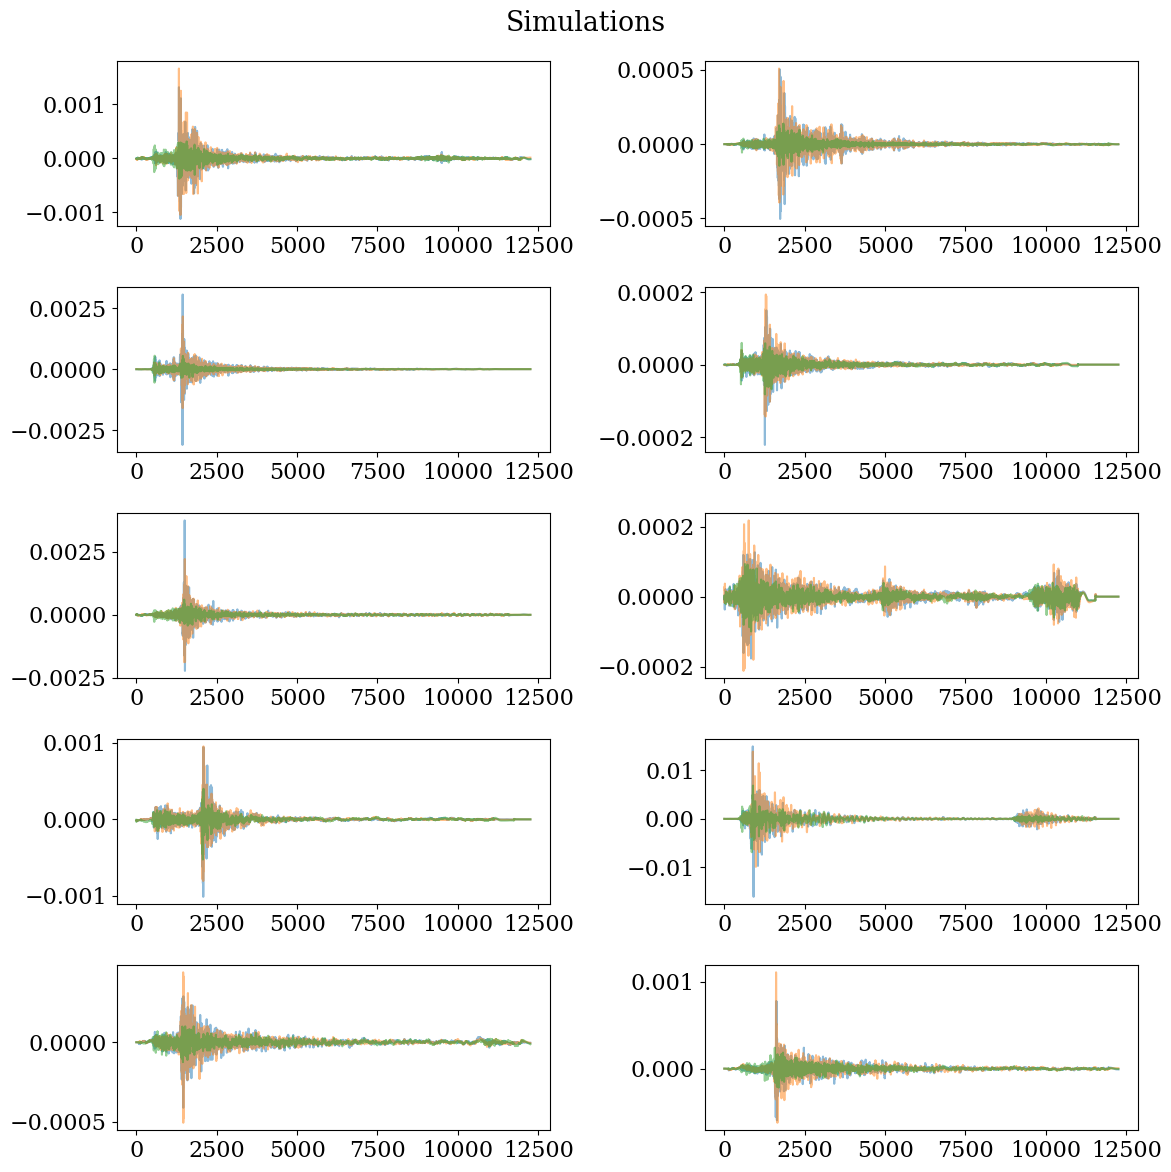

In [45]:
_, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
for i in range(0, 5, 1):
    axes[i][0].plot(targets[i].T, alpha=0.5)
    axes[i][1].plot(targets[i + 5].T, alpha=0.5)
plt.suptitle("Training data")
plt.tight_layout()
plt.savefig("workdir/figures/new_targets.pdf")
plt.show()

_, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
for i in range(0, 5, 1):
    axes[i][0].plot(preds[i].T, alpha=0.5)
    axes[i][1].plot(preds[i + 5].T, alpha=0.5)
plt.suptitle("Simulations")
plt.tight_layout()
plt.savefig("workdir/figures/new_preds.pdf")
plt.show()

In [5]:
mag_bins = config.mag_bins
dist_bins = config.dist_bins
evaluation_dir =  "workdir/evaluation/"


# Matplotlib settings
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = False
rcParams["font.size"] = 16

## Data distribution
Create the plot for the binning of the data and the heatmap for the number of samples in each bin.

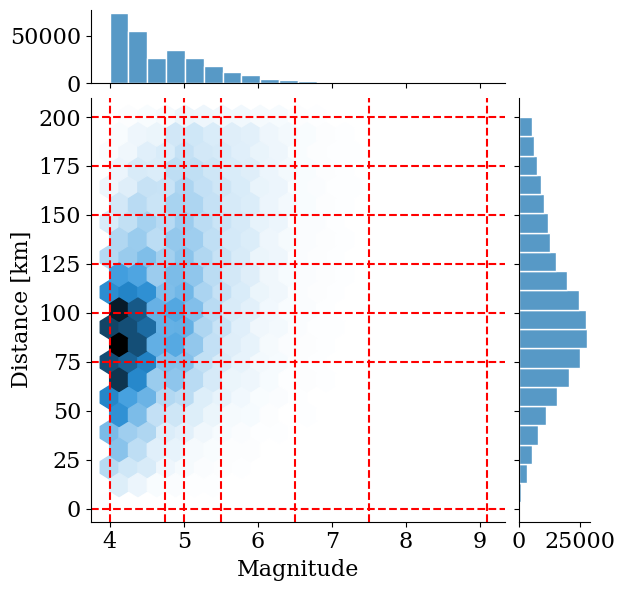

In [8]:
mag = full_dataset.file["magnitude"][:]
dist = full_dataset.file["hypocentral_distance"][:]

fig = sns.jointplot(
    x=mag,
    y=dist,
    kind="hex",
    marginal_ticks=True,
    joint_kws=dict(gridsize=20),
    marginal_kws=dict(bins=20, edgecolor="white"),
)
# plot.figure.set_size_inches([fig_width, fig_width])
plt.xlabel("Magnitude")
plt.ylabel("Distance [km]")

# draw bins
for x in mag_bins:
    plt.axvline(x, color="red", linestyle="--")
for y in dist_bins:
    plt.axhline(y, color="red", linestyle="--")

fig.savefig("workdir/figures/binning.pdf")

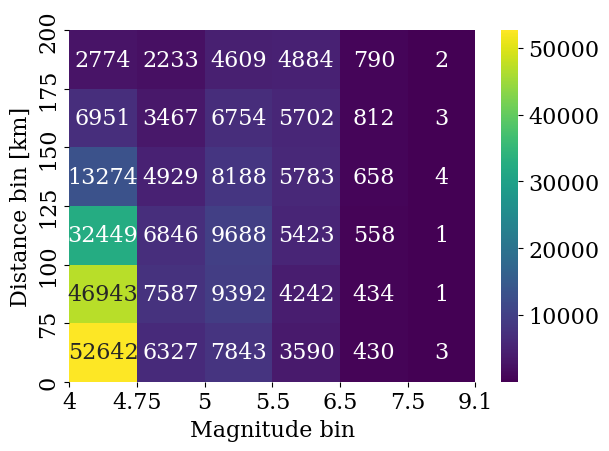

In [37]:
size_metric = lambda x, *args, **kwargs: len(x)
fig = BinPlot(metric=size_metric, mag_bins=mag_bins, dist_bins=dist_bins, fmt="d")(
    pred=mag, target=mag, mag=mag, dist=dist
)
fig.savefig("workdir/figures/class_distribution.pdf")

## Embedding Frechet Distance (FID)

In [ ]:
print(
    f"Generated vs Real: {round(frechet_distance(full['predicted_classifier_embedding'][:], full['target_classifier_embedding'][:], isotropic=True), 2)}"
)

print(
    f"Generated vs Test: {round(frechet_distance(test['predicted_classifier_embedding'][:], test['target_classifier_embedding'][:], isotropic=True), 2)}"
)

print(
    f"Train vs Test: {round(frechet_distance(train['target_classifier_embedding'][:], test['target_classifier_embedding'][:], isotropic=True), 2)}"
)

In [ ]:
print(
    f"Generated vs Real: {round(frechet_distance(full['predicted_classifier_embedding'][:], full['target_classifier_embedding'][:], isotropic=True), 2)}"
)

print(
    f"Generated vs Test: {round(frechet_distance(test['predicted_classifier_embedding'][:], test['target_classifier_embedding'][:], isotropic=True), 2)}"
)

print(
    f"Train vs Test: {round(frechet_distance(train['target_classifier_embedding'][:], test['target_classifier_embedding'][:], isotropic=True), 2)}"
)a

Generated vs Real: 3.390000104904175
Generated vs Test: 3.309999942779541
Train vs Test: 0.05999999865889549


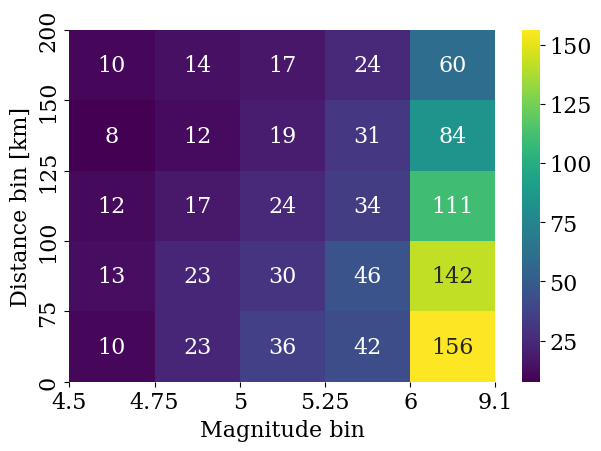

In [16]:
fid_metric = lambda x, y: frechet_distance(x, y, isotropic=False)
fig = BinPlot(metric=fid_metric, mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_classifier_embedding"][:],
    target=full["target_classifier_embedding"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/embedding_fd_heatmap.pdf")

## Classifier Accuracy

In [17]:
def get_label(mag, dist):
    return (np.digitize(dist, dist_bins) - 1) * (len(mag_bins) - 1) + np.digitize(mag, mag_bins) - 1


def accuracy(logits, labels):
    return (logits.argmax(axis=-1) == labels).mean() * 100

In [24]:
print(
    f"Generated Full: {round(accuracy(full['predicted_classifier_pred'][:], get_label(full['magnitude'][:], full['hypocentral_distance'][:])), 2)} %"
)
print(
    f"Generated Test: {round(accuracy(test['predicted_classifier_pred'][:], get_label(test['magnitude'][:], test['hypocentral_distance'][:])), 2)} %"
)
print(
    f"Test: {round(accuracy(test['target_classifier_pred'][:], get_label(test['magnitude'][:], test['hypocentral_distance'][:])), 2)} %"
)

Generated Full: 44.48 %
Generated Test: 44.48 %
Test: 57.67 %


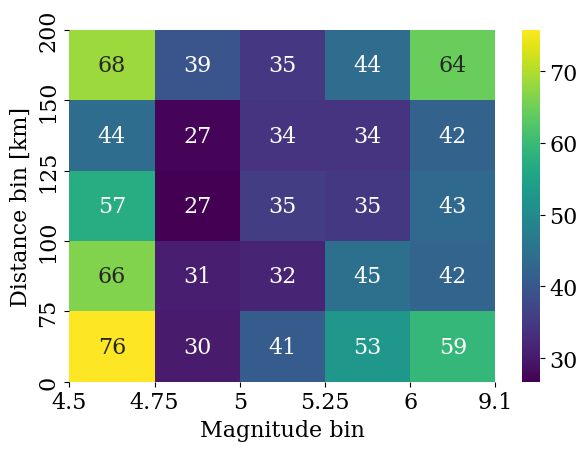

In [12]:
fig = BinPlot(metric=accuracy, mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_classifier_pred"][:],
    target=get_label(
        full["magnitude"][:], full["hypocentral_distance"][:]
    ),  # missusing target for labels
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/accuracy_heatmap.pdf")

## Amplitude Spectral Density

In [3]:
print(
    f"Channel 0: Generated vs Real: {round(AmplitudeSpectralDensity(100, 0)(full['predicted_waveform'][:], full['target_waveform'][:]), 2)}"
)

print(
    f"Channel 0: Generated vs Test: {round(AmplitudeSpectralDensity(100, 0)(test['predicted_waveform'][:], test['target_waveform'][:]), 2)}"
)

print(
    f"Channel 0: Train vs Test: {round(AmplitudeSpectralDensity(100, 0)(train['target_waveform'][:], test['target_waveform'][:]), 2)}"
)

print()

print(
    f"Channel 1: Generated vs Real: {round(AmplitudeSpectralDensity(100, 1)(full['predicted_waveform'][:], full['target_waveform'][:]), 2)}"
)

print(
    f"Channel 1: Generated vs Test: {round(AmplitudeSpectralDensity(100, 1)(test['predicted_waveform'][:], test['target_waveform'][:]), 2)}"
)

print(
    f"Channel 1: Train vs Test: {round(AmplitudeSpectralDensity(100, 1)(train['target_waveform'][:], test['target_waveform'][:]), 2)}"
)

print()

print(
    f"Channel 2: Generated vs Real: {round(AmplitudeSpectralDensity(100, 2)(full['predicted_waveform'][:], full['target_waveform'][:]), 2)}"
)

print(
    f"Channel 2: Generated vs Test: {round(AmplitudeSpectralDensity(100, 2)(test['predicted_waveform'][:], test['target_waveform'][:]), 2)}"
)

print(
    f"Channel 2: Train vs Test: {round(AmplitudeSpectralDensity(100, 2)(train['target_waveform'][:], test['target_waveform'][:]), 2)}"
)

Channel 0: Generated vs Real: 60.98
Channel 0: Generated vs Test: 66.61
Channel 0: Train vs Test: 0.22

Channel 1: Generated vs Real: 47.84
Channel 1: Generated vs Test: 52.34
Channel 1: Train vs Test: 0.2

Channel 2: Generated vs Real: 56.73
Channel 2: Generated vs Test: 60.18
Channel 2: Train vs Test: 0.24


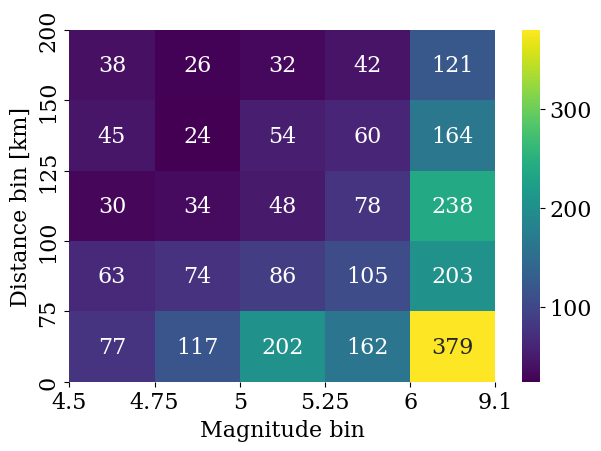

In [13]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 0, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/asd_heatmap_0.pdf")

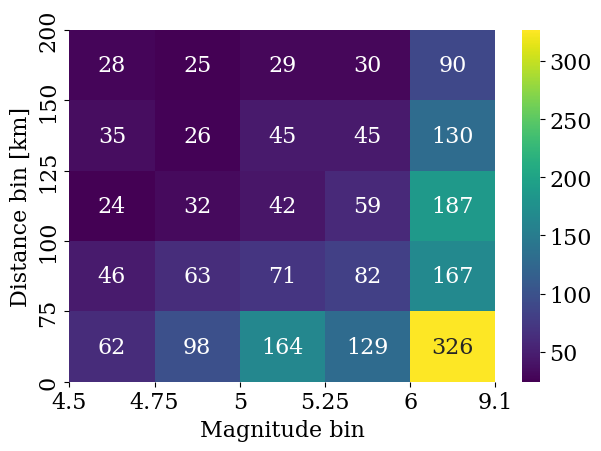

In [14]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 1, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/asd_heatmap_1.pdf")

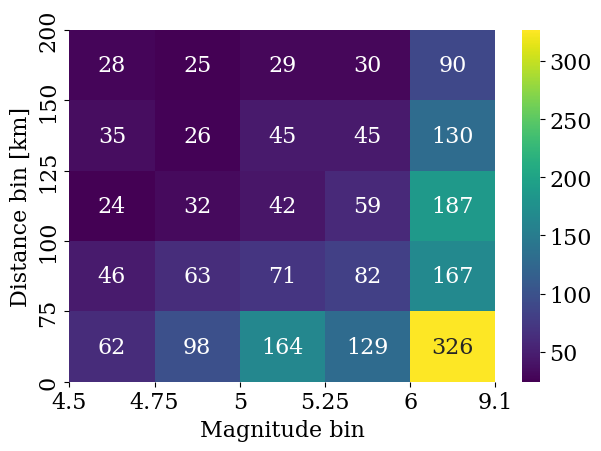

In [15]:
fig = BinPlot(metric=AmplitudeSpectralDensity(100, 1, isotropic=True), mag_bins=mag_bins, dist_bins=dist_bins, fmt=".0f")(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/asd_heatmap_2.pdf")

## Grid plot

In [6]:
distance_bins = config.dist_bins
magnitude_bins = config.mag_bins
channel = 2

ValueError: Cannot apply_along_axis when any iteration dimensions are 0

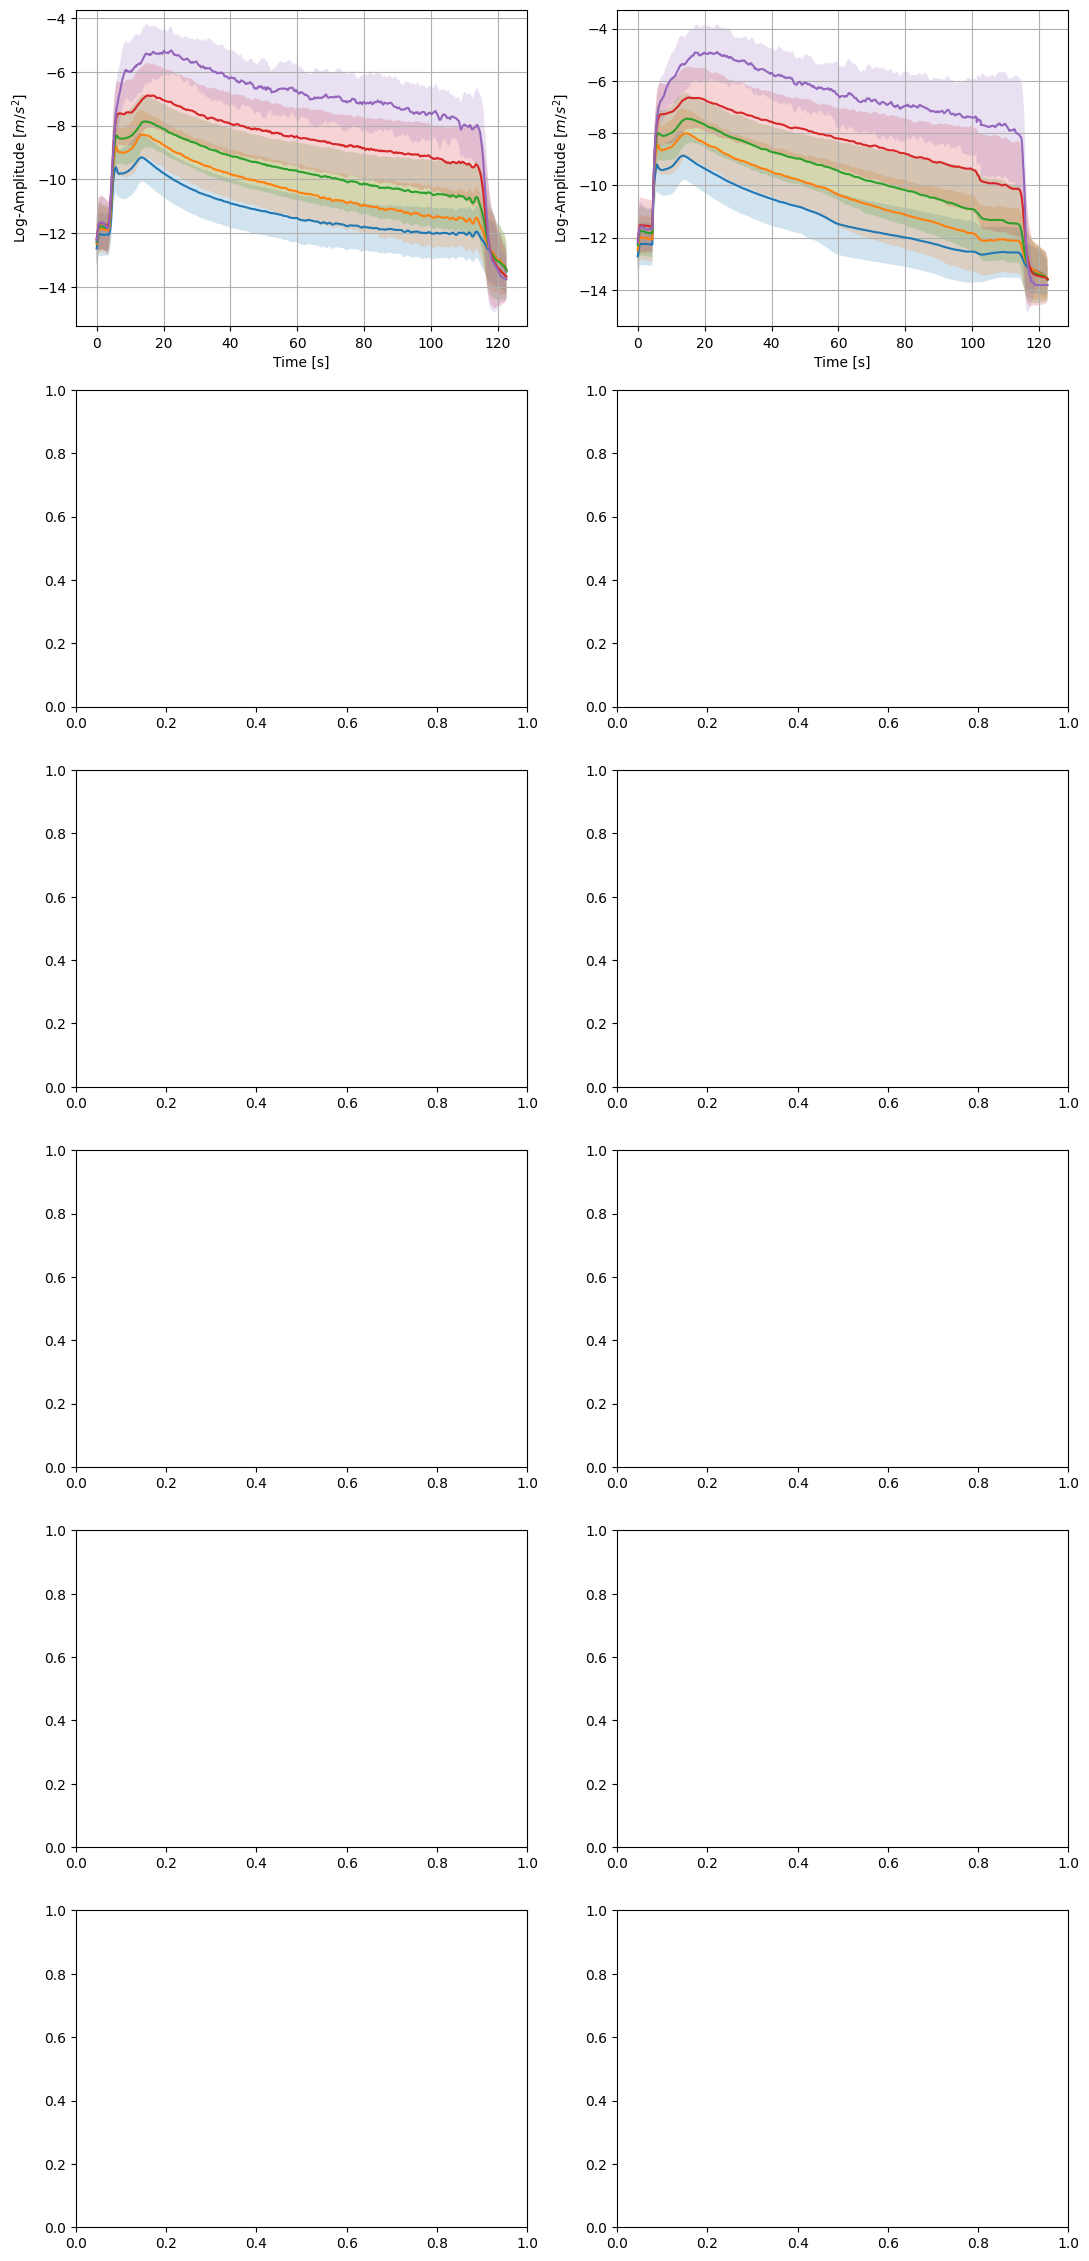

In [ ]:
fig = MovingAverageEnvelopeGrid(fs=config.fs, channel=channel, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=test["predicted_waveform"][:],
    target=test["target_waveform"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)
fig.savefig(f"workdir/figures/moving_average_envelope_grid_{channel}.pdf", bbox_inches="tight")

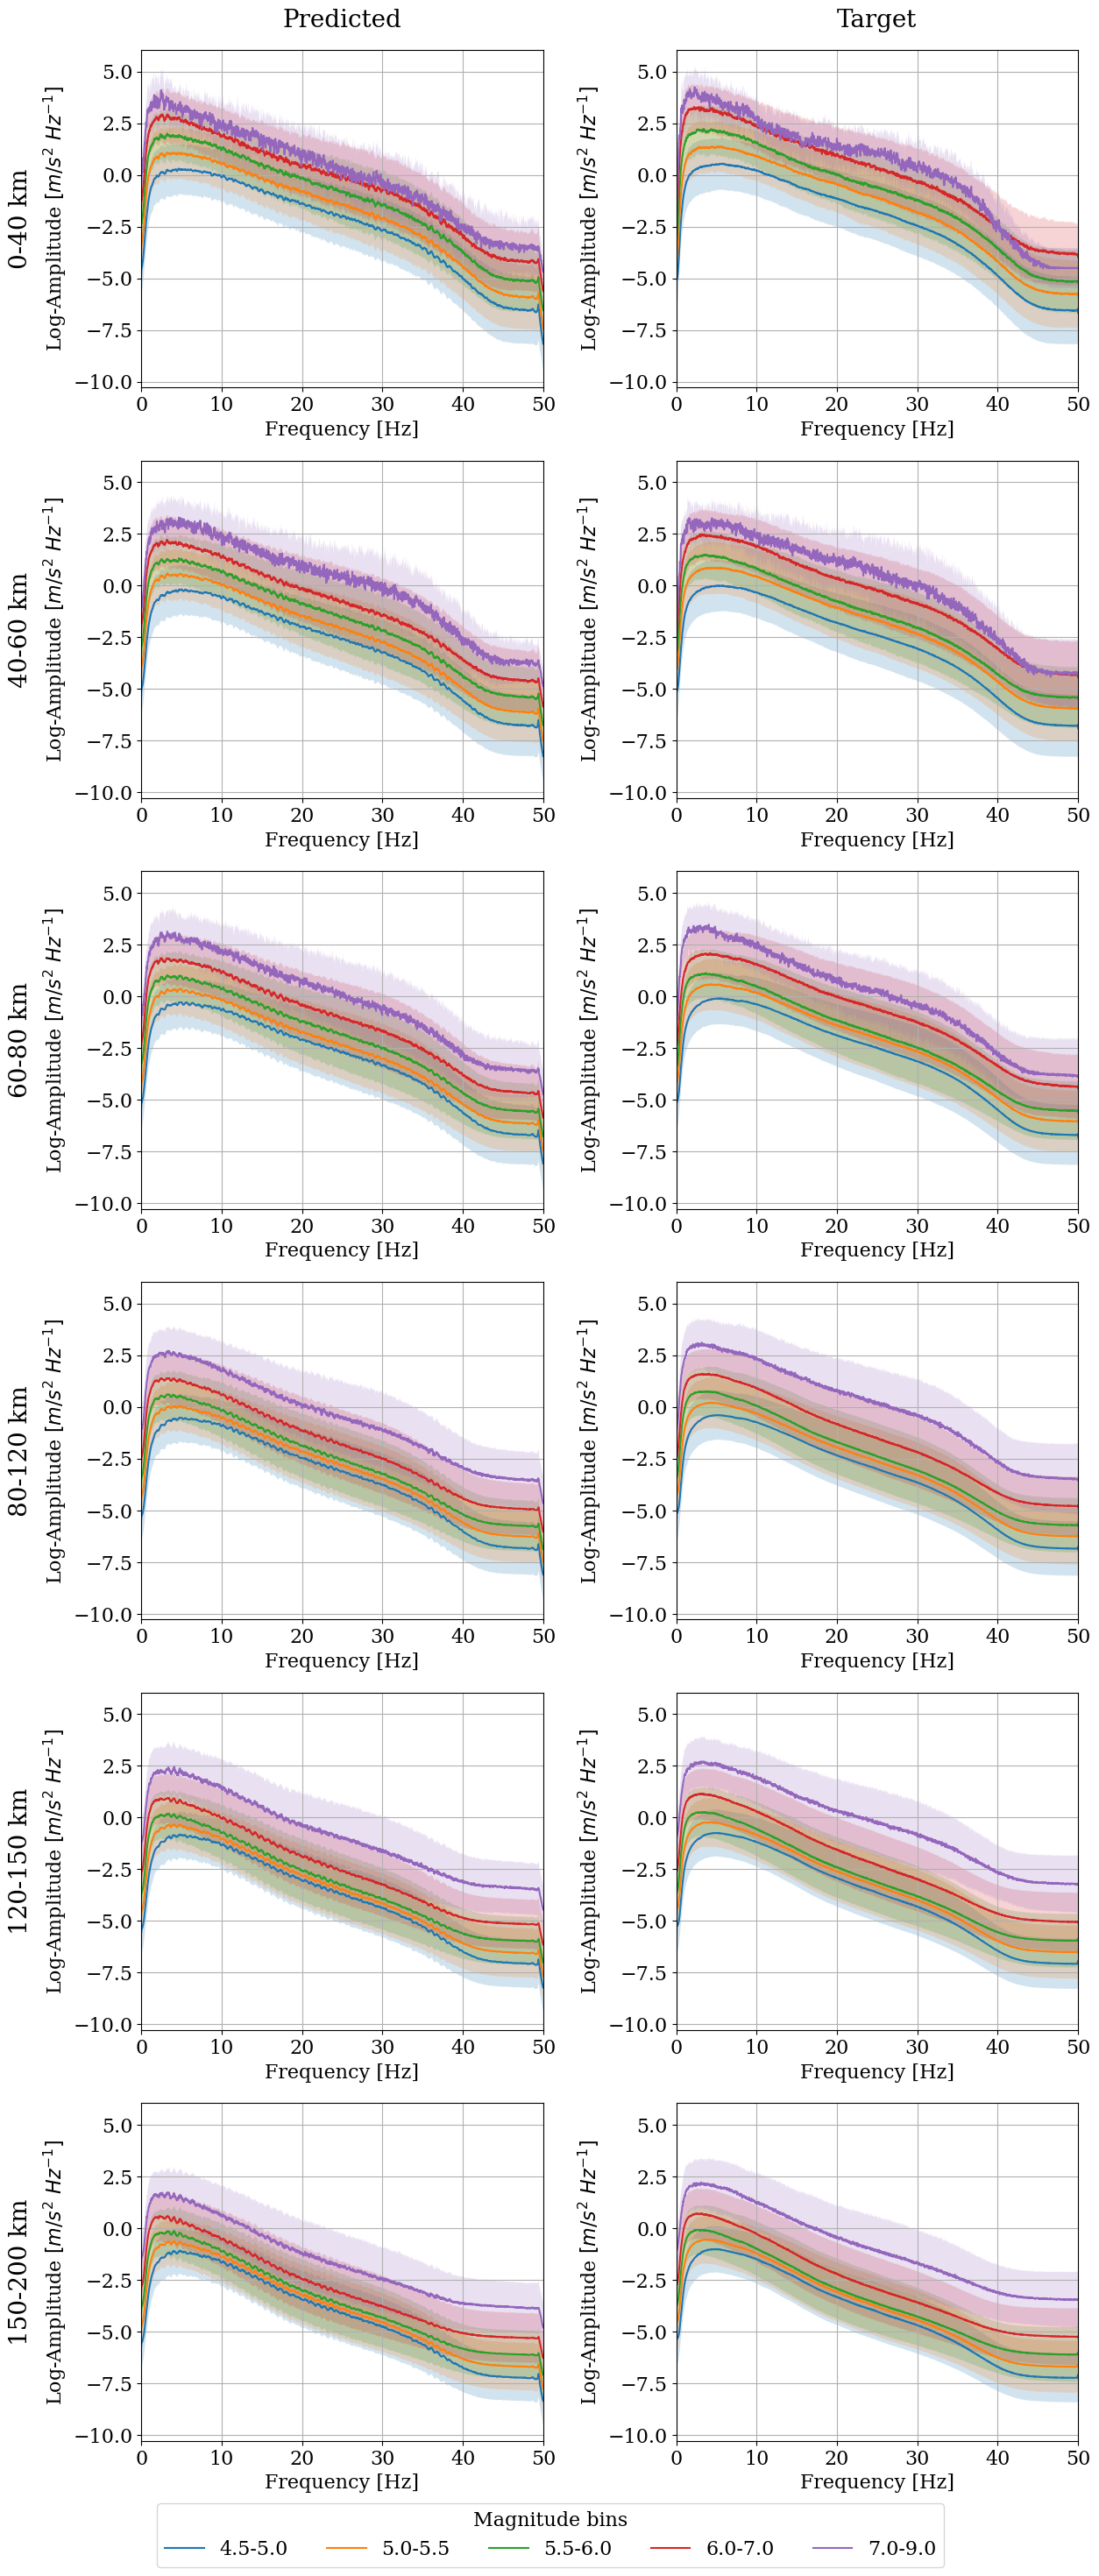

In [ ]:
fig = AmplitudeSpectralDensityGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=test["predicted_waveform"][:],
    target=test["target_waveform"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)
fig.savefig(f"../figures/asd_grid_{channel}.pdf", bbox_inches="tight")

### Single distance bin

In [31]:
distance_bins = [0, 200]
magnitude_bins = [4.5, 5.0, 5.5, 6.0, 7.0, 9.0]

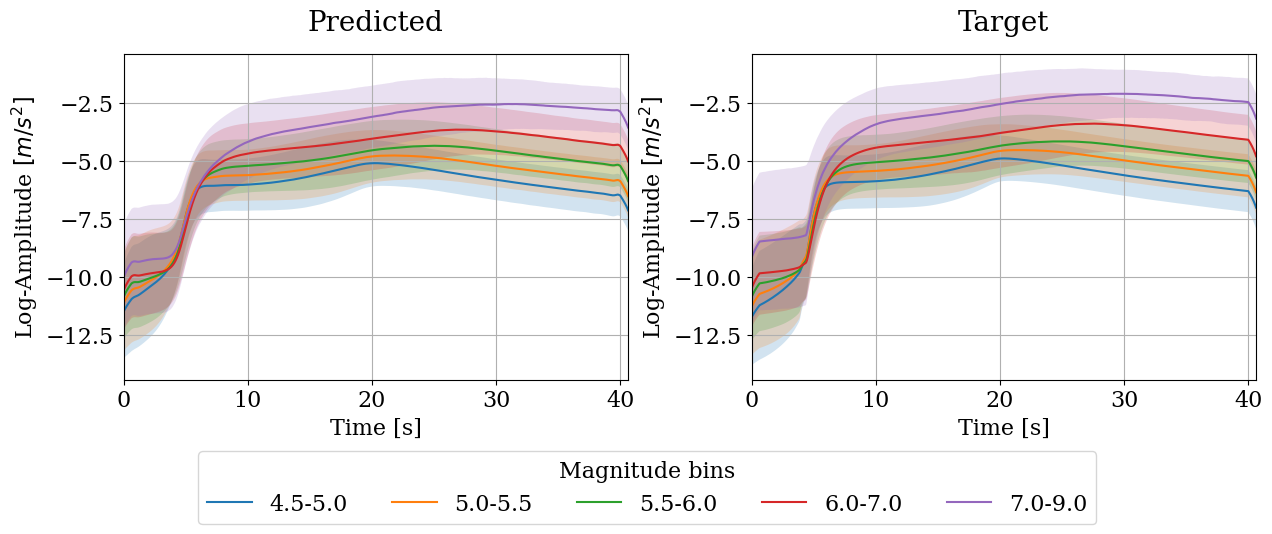

In [33]:
fig = MovingAverageEnvelopeGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=full["predicted_waveform"][:],
    target=full["target_waveform"][:],
    mag=full["magnitude"][:],
    dist=full["hypocentral_distance"][:],
)
fig.savefig("../figures/moving_average_envelope_small_grid.pdf", bbox_inches="tight")

In [ ]:
fig = AmplitudeSpectralDensityGrid(fs=config.fs, channel=0, mag_bins=magnitude_bins, dist_bins=distance_bins)(
    pred=test["predicted_waveform"][:],
    target=test["target_waveform"][:],
    mag=test["magnitude"][:],
    dist=test["hypocentral_distance"][:],
)
fig.savefig("../figures/asd_small_grid.pdf", bbox_inches="tight")

/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/src/tqdne/tqdne/plot.py:230: RuntimeWarning: Mean of empty slice.
  mean = transformed.mean(axis=0)
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/capstor/scratch/cscs/sdirmeie/PROJECTS/highfem/workdir/envs/tqdne-dev/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in div

KeyboardInterrupt: 